# Convolutional Sequence to Sequence Learning

This notebook implements the model in:  
Gehring, J., Auli, M., Grangier, D., Yarats, D., and Dauphin, Y. N. 2017. Convolutional sequence to sequence learning. In Proceedings of the 34th International Conference on Machine Learning-Volume 70, 1243-1252. [arXiv:1705.03122](https://arxiv.org/abs/1705.03122).  

This model is based on an *Encoder-Decoder* framework, in which the encoder and the decoder are both CNNs.  
* The source and target embeddings are $e = \{ e_1, e_2, \dots, e_m \}$ and $g = \{ g_1, g_2, \dots, g_n \}$, which are both built from element-wise addition of token embeddings and positional embeddings. 
* The output of the $l$-th layer/block is $z^l = \{ z_1^l, z_2^l, \dots, z_m^l \}$ for the encoder, and $h^l = \{ h_1^l, h_2^l, \dots, h_n^l \}$ for the decoder.  
* The encoder encodes all the information of the source sequence into the output $z^u$ (`encoder conved` in the figure) of its top block $u$; and combine it via a residual connection with source embeddings $e$ to form $z^u + e$ (`encoder combined` in the figure).  
* When decoding, each decoder layer applies an attention mechanism over the encoder's outputs. For each decoding step $i$, the query is a residual connection result of convolutional output $h_i^l$ and target embedding $g_i$; the keys are $z^u$ and the values are $z^u + e$. The attentioned values are then combined with the convolutional output $h_i^l$ to form the final output of the current block.  
* For every block in the encoder and the deocder, a residual connection is applied.  

![Conv Seq2Seq Learning](fig/conv-seq2seq-learning.png)

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 515
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

In [2]:
import spacy
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    """
    Tokenize German text. 
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenize English text.
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [3]:
from torchtext.data import Field, BucketIterator

# Set `batch_first=True` in the `Field`.
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', 
            lower=True, include_lengths=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', 
            lower=True, include_lengths=True, batch_first=True)

In [4]:
from torchtext.datasets import Multi30k

train_data, valid_data, test_data = Multi30k.splits(exts=['.de', '.en'], 
                                                    # fields=[SRC, TRG], 
                                                    fields=[('src', SRC), ('trg', TRG)], 
                                                    root="../assets/data")

In [5]:
print(train_data[0].src)
print(train_data[0].trg)

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [6]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

len(SRC.vocab), len(TRG.vocab)

(7854, 5893)

In [7]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, device=device)

In [8]:
for batch in train_iterator:
    batch_src, batch_src_lens = batch.src
    batch_trg, batch_trg_lens = batch.trg
    break
print(batch_src)
print(batch_src_lens)
print(batch_trg)
print(batch_trg_lens)

tensor([[  2,   5,  13,  ...,   1,   1,   1],
        [  2,   5,  13,  ...,   1,   1,   1],
        [  2,  43, 253,  ...,   1,   1,   1],
        ...,
        [  2,   5,  13,  ...,   1,   1,   1],
        [  2,  18,  30,  ...,   1,   1,   1],
        [  2,  18,   0,  ...,   1,   1,   1]], device='cuda:0')
tensor([14, 17, 12, 11, 17, 21, 12, 16, 14, 11, 23, 23,  8, 11,  9, 14, 19, 20,
        12, 16,  9, 11, 13, 20, 21, 29, 13, 22, 14, 16, 10,  9, 15, 12, 17, 10,
        14, 22, 17, 20, 23, 23, 12, 17, 15, 19, 17, 15, 16,  7, 14, 15, 16, 12,
        17, 14, 18, 18, 14, 14, 17, 21, 12, 12,  9, 19, 12, 14, 12, 11, 10, 13,
        18, 14,  9, 11, 10, 12, 10, 25, 14, 18, 15, 16, 15, 18, 13,  9, 21, 11,
        20, 12, 13, 14, 14, 17, 10, 13, 18, 30, 14, 12, 13,  9, 10, 15, 13, 10,
        12, 15, 13, 18, 17, 13, 11, 12, 10, 16, 12, 13, 24, 14, 19, 19, 10, 20,
        12, 11], device='cuda:0')
tensor([[   2,    4,    9,  ...,    1,    1,    1],
        [   2,    4,    9,  ...,    1,    1,   

## Build Model
### Encoder
* Use CNN instead of RNN.  
* Residual connection.  
* *Token Embeddings* + *Positional Embeddings*.  
* Convolutional Blocks
    * Add $(filter\_size - 1)/2$ padding elements on *each side* of the sequence.   
    * Use *GLU* (*Gated Linear Units*) as the activation function.  
        * GLU will half the hidden dimension.  
    * Residual connection  


GLU formula:  
$$
\mathrm{GLU}(a, b) = a \otimes \mathrm{sigmoid}(b)
$$
where $a$ and $b$ are inputs in the same shape, and $\otimes$ is element-wise product.  

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, pad_idx, max_len=100):
        super().__init__()
        self.kernel_size = kernel_size
        self.scale = 0.5**0.5

        self.tok_emb = nn.Embedding(in_dim, emb_dim, padding_idx=pad_idx)
        self.pos_emb = nn.Embedding(max_len, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        # The `kernel_size` must be odd. 
        self.convs = nn.ModuleList([nn.Conv1d(hid_dim, hid_dim*2, kernel_size=kernel_size, 
                                              padding=(kernel_size-1)//2) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask):
        # src/mask: (batch, step)
        pos = torch.arange(src.size(1), device=src.device).repeat(src.size(0), 1)
        
        # Element-wise addition
        # embedded: (batch, step, emb_dim)
        embedded = self.tok_emb(src) + self.pos_emb(pos)
        embedded = self.dropout(embedded)

        # hidden: (batch, hid_dim=channels, step)
        hidden = self.emb2hid(embedded).permute(0, 2, 1)
        # Fill the padding positions with zeros, consistent with CNN padding. 
        # Fill the padding positions every time before passing to a conv-layer. 
        hidden.masked_fill_(mask.unsqueeze(1), 0)
        
        for i, conv in enumerate(self.convs):
            # conved: (batch, hid_dim*2, step)
            conved = conv(self.dropout(hidden))
            # `F.glu`: the `input` is split in half along `dim` to form `a` and `b`. 
            # conved: (batch, hid_dim, step)
            conved = F.glu(conved, dim=1)
            # Residual connection
            hidden = (hidden + conved) * self.scale
            # Fill the padding positions with zeros, consistent with CNN padding. 
            # Fill the padding positions every time before passing to a conv-layer. 
            hidden.masked_fill_(mask.unsqueeze(1), 0)

        # conv_outs: (batch, step, emb_dim)
        conv_outs = self.hid2emb(hidden.permute(0, 2, 1))
        conv_outs.masked_fill_(mask.unsqueeze(2), 0)
        # Residual connection
        # combined: (batch, step, emb_dim)
        combined = (embedded + conv_outs) * self.scale
        combined.masked_fill_(mask.unsqueeze(2), 0)

        return conv_outs, combined

In [10]:
SRC_IN_DIM = len(SRC.vocab)
TRG_IN_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512
ENC_N_LAYERS = 10
DEC_N_LAYERS = 10
ENC_KERNEL_SIZE = 3 # Must be odd
DEC_KERNEL_SIZE = 3 # Can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
ENC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
DEC_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

encoder = Encoder(SRC_IN_DIM, EMB_DIM, HID_DIM, ENC_N_LAYERS, ENC_KERNEL_SIZE, 
                  ENC_DROPOUT, ENC_PAD_IDX).to(device)

mask = (batch_src == encoder.tok_emb.padding_idx)
enc_conv_outs, enc_combined = encoder(batch_src, mask)

print(batch_src.size())
print(enc_conv_outs.size())
print(enc_combined.size())

torch.Size([128, 30])
torch.Size([128, 30, 256])
torch.Size([128, 30, 256])


In [11]:
print(((enc_conv_outs == 0) == mask.unsqueeze(2)).all())
print(((enc_combined == 0) == mask.unsqueeze(2)).all())

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')


### Decoder
* Use CNN instead of RNN.  
* Residual connection.  
* *Token Embeddings* + *Positional Embeddings*.  
* Convolutional Blocks
    * Add $filter\_size - 1$ padding elements at the *beginning* of the sequence.   
    * Use *GLU* (*Gated Linear Units*) as the activation function.  
        * GLU will half the hidden dimension.  
    * Residual connection  
* Attention  
    * Query: the embedding of current word  
    * Keys: the encoded representations - `conv_outs`  
        * `conv_outs` is good for getting a larger context over the encoded sequence  
    * Values: the encoded representations - `combined`  
        * `combined` has more information about the specific token and is thus more useful for prediction  

In [12]:
class Attention(nn.Module):
    """
    A dot-product attention. 
    """
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys, values, mask):
        """
        Multi-step forward. 
        """
        # queries: (batch, trg_step, emb_dim)
        # keys: (batch, src_step, emb_dim)
        # values: (batch, src_step, emb_dim)
        # mask: (batch, src_step)

        # energy/attens: (batch, trg_step, src_step)
        energy = queries.bmm(keys.permute(0, 2, 1))
        energy.masked_fill_(mask.unsqueeze(1), -np.inf)

        # Attention along the source sequence
        attens = F.softmax(energy, dim=-1)

        # Apply the attention
        # attened_values: (batch, trg_step, emb_dim)
        return attens, attens.bmm(values)

In [13]:
attention = Attention()

# Use `combined` as an pseudo queries for checking. 
attens, attened_values = attention(enc_combined, enc_conv_outs, enc_combined, mask)
print(attens.size())
print(attened_values.size())

torch.Size([128, 30, 30])
torch.Size([128, 30, 256])


In [14]:
print(attens.sum(dim=-1))
print((attens == 0) == mask.unsqueeze(1))

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='cuda:0', grad_fn=<SumBackward1>)
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, T

#### Is it necessary to fill the length padding positions with zeros?  
NO. Because the convolutional paddings are all at the sequence begining, so that the conv-layer would be forbidden to look at the token that it tries to predict. Hence, the elements in the length padding positions are also forbidden to pass to the valid (non-padding) positions in the upper layer. 

In [15]:
class Decoder(nn.Module):
    def __init__(self, in_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, pad_idx, max_len=100):
        super().__init__()
        self.kernel_size = kernel_size
        self.scale = 0.5**0.5

        self.tok_emb = nn.Embedding(in_dim, emb_dim, padding_idx=pad_idx)
        self.pos_emb = nn.Embedding(max_len, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        self.attention = Attention()
        self.atten_emb2hid = nn.Linear(emb_dim, hid_dim)
        self.atten_hid2emb = nn.Linear(hid_dim, emb_dim)

        self.convs = nn.ModuleList([nn.Conv1d(hid_dim, hid_dim*2, 
                                              kernel_size=kernel_size) for _ in range(n_layers)])
        
        self.fc = nn.Linear(emb_dim, in_dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self, trg, enc_conv_outs, enc_combined, mask):
        # trg: (batch, trg_step)
        pos = torch.arange(trg.size(1), device=trg.device).repeat(trg.size(0), 1)

        # Element-wise addition
        # embedded: (batch, trg_step, emb_dim)
        embedded = self.tok_emb(trg) + self.pos_emb(pos)
        embedded = self.dropout(embedded)
        
        # hidden: (batch, hid_dim=channels, trg_step)
        hidden = self.emb2hid(embedded).permute(0, 2, 1)
        # Note: For the decoder, NO need to fill the padding positions with zeros. 
        # begin_padding: (batch, hid_dim, kernel_size-1)
        begin_padding = torch.zeros(hidden.size(0), hidden.size(1), self.kernel_size-1, device=trg.device)

        for i, conv in enumerate(self.convs):
            # Manually pad zeros at the beginning. 
            padded_hidden = torch.cat([begin_padding, self.dropout(hidden)], dim=-1)
            # conved: (batch, hid_dim*2, trg_step)
            conved = conv(padded_hidden)
            # `F.glu`: the `input` is split in half along `dim` to form `a` and `b`. 
            # conved: (batch, hid_dim, step)
            conved = F.glu(conved, dim=1)

            # conved_projected: (batch, trg_step, emb_dim)
            conved_projected = self.atten_hid2emb(conved.permute(0, 2, 1))
            # attens: (batch, trg_step, src_step)
            # attened_values: (batch, trg_step, emb_dim)
            attens, attened_values = self.attention((embedded + conved_projected)*self.scale, 
                                                    enc_conv_outs, enc_combined, mask)

            # attened_projected: (batch, hid_dim, trg_step)
            attened_projected = self.atten_emb2hid(attened_values).permute(0, 2, 1)
            conved_attened = (conved + attened_projected) * self.scale

            # Residual connection
            # Note: For the decoder, NO need to fill the padding positions with zeros. 
            hidden = (hidden + conved_attened) * self.scale
            
        # conv_outs: (batch, trg_step, emb_dim)
        conv_outs = self.hid2emb(hidden.permute(0, 2, 1))
        # preds: (batch, trg_step, out_dim=in_dim)
        preds = self.fc(self.dropout(conv_outs))

        # Only attention at the top layer?
        return preds, attens

In [16]:
decoder = Decoder(TRG_IN_DIM, EMB_DIM, HID_DIM, DEC_N_LAYERS, DEC_KERNEL_SIZE, 
                  DEC_DROPOUT, DEC_PAD_IDX).to(device)

preds, attens = decoder(batch_trg, enc_conv_outs, enc_combined, mask)

print(batch_trg.size())
print(preds.size())
print(attens.size())

torch.Size([128, 29])
torch.Size([128, 29, 5893])
torch.Size([128, 29, 30])


### Seq2Seq

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        # src/mask: (batch, src_step)
        # trg: (batch, trg_step)
        mask = (src == self.encoder.tok_emb.padding_idx)
        enc_conv_outs, enc_combined = self.encoder(src, mask)
        # For the target sequence, the `<eos>` token should be sliced off before passing to the decoder. 
        # As there are no more tokens to be predicted after `<eos>`. 
        preds, attens = self.decoder(trg[:, :-1], enc_conv_outs, enc_combined, mask)

        # preds: (batch, trg_step-1, trg_out_dim)
        # attens: (batch, trg_step-1, src_step)
        return preds, attens

    def translate(self, src, sos: int, trg_max_len: int=50):
        # Ensure `dropout` off, or the result would change randomly. 
        self.eval()
        # src/mask: (batch, src_step)
        mask = (src == self.encoder.tok_emb.padding_idx)
        enc_conv_outs, enc_combined = self.encoder(src, mask)
        # For the target sequence, the `<eos>` token should be sliced off before passing to the decoder. 
        # As there are no more tokens to be predicted after `<eos>`. 

        # Create an target sequence. 
        # trg: (batch, trg_step)
        trg = torch.ones(src.size(0), trg_max_len, 
                         dtype=torch.long, device=src.device) * sos

        # The inference would be slow, since there is much repeated computation. 
        for t in range(1, trg.size(1)):
            # (1) DO NOT only use the positions in a filter size before the token to be predicted. 
            # Since there are multiple conv-layers, the decoder may use all the previous tokens 
            # to predict the next token. 
            # (2) The input target sequence should be `trg[:, :(t+1)]`; with `<eos>` token sliced off, 
            # it becomes `trg[:, :t]`. Note that the elements in step `t-1` is just predicted in the 
            # last loop.  
            # preds_t: (batch, trg_step-1=t, trg_out_dim)
            # atten_t: (batch, trg_step-1=t, src_step)
            preds_t, attens_t = self.decoder(trg[:, :t], enc_conv_outs, enc_combined, mask)

            # top1: (batch, )
            top1 = preds_t[:, -1].argmax(dim=-1)
            trg[:, t] = top1
            
        # The decoder's output at the last step is the desired result (over all steps). 
        # `trg[:, 1:]` equals `preds_t.argmax(dim=-1)` - if the `dropout` off
        assert (trg[:, 1:] == preds_t.argmax(dim=-1)).all().item()
        return trg[:, 1:], attens_t

In [18]:
model = Seq2Seq(encoder, decoder).to(device)
preds, attens = model(batch_src, batch_trg)

print(batch_src.size())
print(batch_trg.size())
print(preds.size())
print(attens.size())

torch.Size([128, 30])
torch.Size([128, 29])
torch.Size([128, 28, 5893])
torch.Size([128, 28, 30])


In [19]:
DEC_SOS_IDX = TRG.vocab.stoi[TRG.init_token]
DEC_EOS_IDX = TRG.vocab.stoi[TRG.eos_token]
pred_indexes, attens = model.translate(batch_src, DEC_SOS_IDX)

print(pred_indexes.size())
print(attens.size())

torch.Size([128, 49])
torch.Size([128, 49, 30])


In [20]:
# Check if data are mixed across different samples in a batch.
model.eval()
preds_012, _ = model(batch_src[0:3], batch_trg[0:3])
preds_123, _ = model(batch_src[1:4], batch_trg[1:4])
(preds_012[1:] == preds_123[:2]).all()

tensor(True, device='cuda:0')

## Train Model

In [21]:
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

encoder = Encoder(SRC_IN_DIM, EMB_DIM, HID_DIM, ENC_N_LAYERS, ENC_KERNEL_SIZE, 
                  ENC_DROPOUT, ENC_PAD_IDX).to(device)
decoder = Decoder(TRG_IN_DIM, EMB_DIM, HID_DIM, DEC_N_LAYERS, DEC_KERNEL_SIZE, 
                  DEC_DROPOUT, DEC_PAD_IDX).to(device)
model = Seq2Seq(encoder, decoder).to(device)

model.apply(init_weights)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,429 trainable parameters


In [22]:
# Initialize Embeddings 
ENC_UNK_IDX = SRC.vocab.stoi[SRC.unk_token]
DEC_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]

model.encoder.tok_emb.weight.data[ENC_UNK_IDX].zero_()
model.encoder.tok_emb.weight.data[ENC_PAD_IDX].zero_()
model.decoder.tok_emb.weight.data[DEC_UNK_IDX].zero_()
model.decoder.tok_emb.weight.data[DEC_PAD_IDX].zero_()

print(model.encoder.tok_emb.weight[:5, :8])
print(model.decoder.tok_emb.weight[:5, :8])

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0036, -0.0057,  0.0141,  0.0074,  0.0130,  0.0027,  0.0067,  0.0105],
        [-0.0087, -0.0138, -0.0105,  0.0118,  0.0058, -0.0029, -0.0062,  0.0097],
        [ 0.0180,  0.0115, -0.0045,  0.0070, -0.0107, -0.0151, -0.0111,  0.0012]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0144, -0.0001, -0.0140, -0.0133, -0.0042,  0.0002, -0.0093,  0.0181],
        [ 0.0090,  0.0090,  0.0139,  0.0056, -0.0101,  0.0040,  0.0132,  0.0016],
        [ 0.0082, -0.0218, -0.0114, -0.0015, -0.0214,  0.0220,  0.0035,  0.0087]],
       device='cuda:0', grad_fn=<SliceBackward>)


In [23]:
loss_func = nn.CrossEntropyLoss(ignore_index=DEC_PAD_IDX, reduction='mean')
optimizer = optim.AdamW(model.parameters())

In [24]:
def train_epoch(model, iterator, optimizer, loss_func, clip):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        # Forward pass
        batch_src, batch_src_lens = batch.src
        batch_trg, batch_trg_lens = batch.trg
        # preds: (batch, trg_step-1, trg_out_dim)
        preds, _ = model(batch_src, batch_trg)
        
        # Calculate loss
        preds_flattened = preds.view(-1, preds.size(-1))
        batch_trg_flattened = batch_trg[:, 1:].flatten()
        loss = loss_func(preds_flattened, batch_trg_flattened)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update weights
        optimizer.step()
        # Accumulate loss
        epoch_loss += loss.item()
    return epoch_loss/len(iterator)

def eval_epoch(model, iterator, loss_func):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            # Forward pass
            batch_src, batch_src_lens = batch.src
            batch_trg, batch_trg_lens = batch.trg
            # preds: (batch, trg_step-1, trg_out_dim)
            preds, _ = model(batch_src, batch_trg)
            
            # Calculate loss
            preds_flattened = preds.view(-1, preds.size(-1))
            batch_trg_flattened = batch_trg[:, 1:].flatten()
            loss = loss_func(preds_flattened, batch_trg_flattened)
            
            # Accumulate loss and acc
            epoch_loss += loss.item()
    return epoch_loss/len(iterator)

In [25]:
import time
N_EPOCHS = 10
CLIP = 0.1
best_valid_loss = np.inf

for epoch in range(N_EPOCHS):
    t0 = time.time()
    train_loss = train_epoch(model, train_iterator, optimizer, loss_func, CLIP)
    valid_loss = eval_epoch(model, valid_iterator, loss_func)
    epoch_secs = time.time() - t0

    epoch_mins, epoch_secs = int(epoch_secs // 60), int(epoch_secs % 60)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "models/tut5-model.pt")
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 33.847 | Train PPL: 500822639720448.500
	 Val. Loss: 4.014 |  Val. PPL:  55.379
Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 3.832 | Train PPL:  46.177
	 Val. Loss: 3.355 |  Val. PPL:  28.645
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 3.209 | Train PPL:  24.752
	 Val. Loss: 2.683 |  Val. PPL:  14.624
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 2.638 | Train PPL:  13.981
	 Val. Loss: 2.257 |  Val. PPL:   9.550
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 2.245 | Train PPL:   9.438
	 Val. Loss: 1.994 |  Val. PPL:   7.345
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 1.980 | Train PPL:   7.242
	 Val. Loss: 1.878 |  Val. PPL:   6.539
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 1.795 | Train PPL:   6.022
	 Val. Loss: 1.808 |  Val. PPL:   6.099
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 1.649 | Train PPL:   5.203
	 Val. Loss: 1.744 |  Val. PPL:   5.722
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 1.528 | Train PPL:   4.608
	 Val. Loss: 1.718 |  Val. P

In [26]:
model.load_state_dict(torch.load("models/tut5-model.pt", map_location=device))

valid_loss = eval_epoch(model, valid_iterator, loss_func)
test_loss = eval_epoch(model, test_iterator, loss_func)

print(f'Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')
print(f'Test Loss: {test_loss:.3f} |  Test PPL: {np.exp(test_loss):7.3f}')

Val. Loss: 1.691 |  Val. PPL:   5.424
Test Loss: 1.774 |  Test PPL:   5.894


## Check Embeddings
* The Embeddings of `<unk>` and `<pad>` tokens
    * Because the `padding_idx` has been passed to `nn.Embedding`, so the `<pad>` embedding will remain zeros throughout training.  
    * While the `<unk>` embedding will be learned.

In [27]:
print(model.encoder.tok_emb.weight[:5, :8])
print(model.decoder.tok_emb.weight[:5, :8])

tensor([[ 0.0085,  0.0291, -0.0089, -0.0161,  0.0304,  0.0004, -0.0057,  0.0056],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0413,  0.0314,  0.0655,  0.0299,  0.0601, -0.0016, -0.0185, -0.0348],
        [ 0.0791,  0.0149,  0.0439,  0.1041, -0.0042, -0.0675, -0.0707, -0.0045],
        [-0.0041,  0.0445,  0.0800,  0.0848, -0.0290, -0.0478, -0.0472, -0.0305]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[-0.0184, -0.0382,  0.0199,  0.0005, -0.0259, -0.0042, -0.0118,  0.0221],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0023,  0.0028, -0.0035,  0.0056, -0.0034,  0.0107, -0.0124,  0.0110],
        [ 0.0088,  0.0088,  0.0136,  0.0055, -0.0099,  0.0039,  0.0129,  0.0015],
        [ 0.0592,  0.0446,  0.0549,  0.0695,  0.0408,  0.0913,  0.0359, -0.1018]],
       device='cuda:0', grad_fn=<SliceBackward>)


## Inference

In [28]:
def translate(model, src_tokens):
    """
    Single sentence translation.
    """
    model.eval()
    src_indexes = [SRC.vocab.stoi[tok] for tok in src_tokens]
    src = torch.tensor(src_indexes, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        # pred_indexes: (batch, trg_step-1)
        # attens: (batch, trg_step-1, src_step)
        pred_indexes, attens = model.translate(src, DEC_SOS_IDX)

    trans_tokens = []
    for idx in pred_indexes.flatten():
        tok = TRG.vocab.itos[idx.item()]
        trans_tokens.append(tok)
        if tok == TRG.eos_token:
            break
    return trans_tokens, attens.squeeze(0)[:len(trans_tokens)]

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def plot_attention(src_tokens, trans_tokens, attens):
    """
    For each translated token, the associated attention is the attention for predicting 
    the translated token. 
    """
    fig, ax = plt.subplots()
    ax.matshow(attens, cmap='bone')
    ax.set_xticklabels([""] + src_tokens, rotation=90)
    ax.set_yticklabels([""] + trans_tokens)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

<sos> zwei junge weiße männer sind im freien in der nähe vieler büsche . <eos>
two young white men outside near many bushes . <eos>
two young , white males are outside near many bushes .


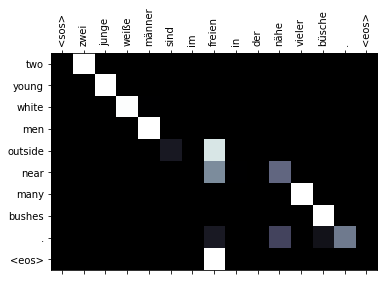

In [30]:
ex_idx = 0
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

<sos> mehrere männer mit schutzhelmen bedienen ein antriebsradsystem . <eos>
several men in hard hats are operating a <unk> . <eos>
several men in hard hats are operating a giant pulley system .


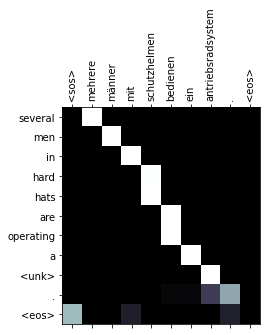

In [31]:
ex_idx = 1
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

<sos> ein kleines mädchen klettert in ein spielhaus aus holz . <eos>
a little girl is climbing into a wooden made of wood . <eos>
a little girl climbing into a wooden playhouse .


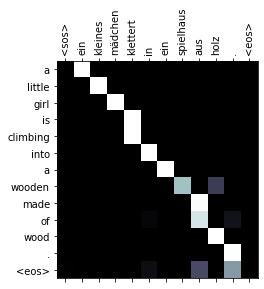

In [32]:
ex_idx = 2
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

<sos> ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster . <eos>
a man in a blue shirt is standing on a ladder cleaning a window . <eos>
a man in a blue shirt is standing on a ladder cleaning a window .


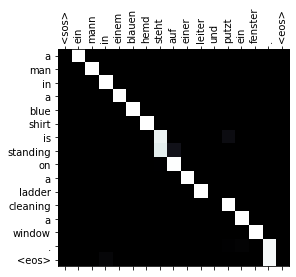

In [33]:
ex_idx = 3
src_tokens = train_data[ex_idx].src
trg_tokens = train_data[ex_idx].trg
src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
trans_tokens, attens = translate(model, src_tokens)
attens = (attens.cpu().numpy() if attens.device.type == 'cuda' else attens.numpy())

print(" ".join(src_tokens))
print(" ".join(trans_tokens))
print(" ".join(trg_tokens))

plot_attention(src_tokens, trans_tokens, attens)

## BLEU

*BLEU* (Bilingual Evaluation Understudy) is a metric measuring the quality of translation.  
BLEU looks at the overlap in the predicted and actual target sequences in terms of their *n-grams*.  
BLEU gives a number between 0 and 1 for each sequence, and a higher BLEU suggests better translation quality.  
BLEU being 1 means a perfect overlap, i.e., a perfect translation.  

In [34]:
from torchtext.data.metrics import bleu_score

def calc_bleu(data):
    trg_data = []
    trans_data = []
    for ex in data:
        src_tokens = ex.src
        trg_tokens = ex.trg
        src_tokens = [SRC.init_token] + src_tokens + [SRC.eos_token]
        trans_tokens, attens = translate(model, src_tokens)

        # The groudtruth may contain multiple actual sentences (right translations). 
        trg_data.append([trg_tokens])
        trans_data.append(trans_tokens[:-1])  # Cut off the <eos> token

    return bleu_score(trans_data, trg_data)

In [35]:
bleu = calc_bleu(test_data)

print(f'BLEU score is: {bleu*100:.2f}')

BLEU score is: 37.22
